<a href="https://www.kaggle.com/code/nyagami/a-deep-dive-into-the-video-games-dataset?scriptVersionId=123233079" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="font-family:monospace">1. Introduction</span>

<p style="font-size:18px">The dataset is obtained <a href="https://www.kaggle.com/datasets/nyagami/video-game-ratings-from-imdb">here</a> after webscraping the imdb website as shown in this <a href="https://www.kaggle.com/code/nyagami/web-scraping-video-game-ratings-on-imdb">separate notebook.</a></p>

<div style = "font-family:georgia, serif; font-size:17px">
    
It contains eight variables namely:
    <ul>
        <li>Game title</li>
        <li>Launch year</li>
        <li>Game genre</li>
        <li>Game rating</li>
        <li>Number of voters</li>
        <li>Director</li>
        <li>Game description or plot</li>  
    </ul>
</div>

# <span style="font-family:monospace">2. Import required libraries and set default settings</span>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from itertools import product

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/video-game-ratings-from-imdb/imdb_video_game_rating.csv


In [2]:
# Set font size and style
plt.rcParams['font.size'] = 18
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['axes.titlesize'] = 20

# <span style="font-family:monospace">3. Import dataset</span>

In [3]:
games = pd.read_csv('../input/video-game-ratings-from-imdb/imdb_video_game_rating.csv')
display(games.head())

,Unnamed: 0,title,year,genre,rating,votes,directors,plot
0,0,The Last of Us: Part I,2022,"Action, Adventure, Drama",9.8,601,"Matthew Gallant, Bruce Straley",Experience the emotional storytelling and unfo...
1,1,Red Dead Redemption II,2018,"Action, Adventure, Crime",9.7,"36,441",Missing,Amidst the decline of the Wild West at the tur...
2,2,The Witcher 3: Wild Hunt - Blood and Wine,2016,"Action, Adventure, Drama",9.7,"7,610",Konrad Tomaszkiewicz,Geralt is in the southern province of Toussain...
3,3,The Witcher 3: Wild Hunt,2015,"Action, Adventure, Drama",9.7,"26,328",Konrad Tomaszkiewicz,A monster hunter for hire embarks on an epic j...
4,4,The Last of Us,2013,"Action, Adventure, Drama",9.7,"61,103","Neil Druckmann, Bruce Straley","In a hostile, post-pandemic world, Joel and El..."


# <span style="font-family:monospace">4. Data Cleaning and processing</span>

In [4]:
# Drop the first unnamed column
games.drop(columns=['Unnamed: 0'],inplace=True)

## <span style="font-family:monospace; margin-left: 25px">4.1 Cleaning the year column</span>

<div style = "font-family:georgia, serif; font-size:17px">
<ul>
<li>Involves replacing invalid years with np.nan</li>
<li>Converting year to a numeric variable</li>
<li>Generating a decade column to store the decade when the game was produced</li>
</ul>
</div>

In [5]:
# All valid years in the dataset
years_list = games.year.value_counts().index

print('All the years in the dataset')
display(years_list)

All the years in the dataset


Index(['2017', '2015', '2016', '2013', '2018', '2005', '2019', '2003', '2002',
       '2012', '2006', '2014', '2004', '2010', '2000', '2001', '2009', '1999',
       '2011', '2007', '2008', '2020', '1994', '1996', '1998', '1993', '2021',
       '1997', '1995', '1992', '1991', '1990', '1989', '1987', '1988', '2022',
       '1986', '1984', '1983', '1982', '1985', '1981', 'I)', '1980', 'II)',
       '1979', '1978', '1977', '1972', '1976', '1975', 'III)', '1973', '1974',
       '1971', '1969', '1948', '1952', '1958', 'IV)', '1962', 'Video', '1970'],
      dtype='object')

In [6]:
# Extract incorrect years
incorrect_years = [year for year in years_list if (not year.startswith('1')) if (not year.startswith('2'))]

#Show incorrect years
display('Incorrect years',incorrect_years)

'Incorrect years'

['I)', 'II)', 'III)', 'IV)', 'Video']

In [7]:
# Extract games with wrong years
games_year_incorrect = games.loc[games['year'].isin(incorrect_years)]

# Convert incorrect values to nan
games.loc[games['year'].isin(incorrect_years),'year'] = np.nan

In [8]:
# Convert the year column to numeric. 
# Converting to integer type outputs an error due to presence of null values
games['year'] = games['year'].astype('float')

# Let's create a decade column to show the decade when the game was launched
games['decade'] = np.floor(games['year']//10)*10
games.decade.head(10)

0    2020.0
1    2010.0
2    2010.0
3    2010.0
4    2010.0
5    2020.0
6    2010.0
7    2010.0
8    1990.0
9    1990.0
Name: decade, dtype: float64

## <span style="font-family:monospace; margin-left: 25px">4.2 Votes column cleaning</span>

In [9]:
# Convert the votes column to integer
games['votes'] = games.votes.apply(lambda x: x.replace(',','')).astype('int')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12635 entries, 0 to 12634
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      12635 non-null  object 
 1   year       12532 non-null  float64
 2   genre      12635 non-null  object 
 3   rating     12635 non-null  float64
 4   votes      12635 non-null  int64  
 5   directors  12635 non-null  object 
 6   plot       12635 non-null  object 
 7   decade     12532 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 789.8+ KB


# <span style="font-family:monospace">5. Exploratory Data Analysis</span>

## <span style="font-family:monospace; margin-left: 25px">5.1 Game production per decade</span>

<div style = "font-family:georgia, serif; font-size:17px">
    
The production of games has been increasing steadily in each decade. The 1940s, 50s, and 60s had the lowest number of games with one, two and three respectively. The 2020 decade has barely started and the number of games is almost exceeding those produced in the 80s.
</div>

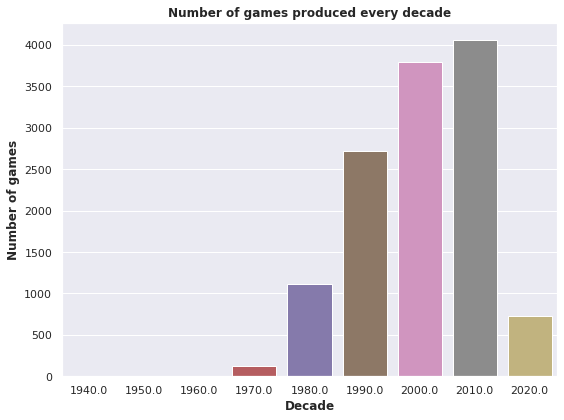

In [10]:
# Visualize the number of games for each decade using a countplot
sns.set()
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x='decade',data=games)
ax.set(title='Number of games produced every decade', xlabel='Decade',ylabel='Number of games')
plt.tight_layout()
plt.show()

## <span style="font-family:monospace; margin-left: 26px">5.2 Highest Rated Games</span>

<div style = "font-family:georgia, serif; font-size:17px">The Last of Us: Part I is the highest rated game in the dataset at 9.8. Among the top 10 highest rated games, two games with their respective sequels appear twice i.e. The Last of Us (2013 and 2022) and The Witcher 3 (2015 and 2016). In the nine decades of game production, not a single game has attained the highest possible rating of 10.</div>

In [11]:
print('10 Highest rated games')
games.nlargest(10,'rating')

10 Highest rated games


,title,year,genre,rating,votes,directors,plot,decade
0,The Last of Us: Part I,2022.0,"Action, Adventure, Drama",9.8,601,"Matthew Gallant, Bruce Straley",Experience the emotional storytelling and unfo...,2020.0
1,Red Dead Redemption II,2018.0,"Action, Adventure, Crime",9.7,36441,Missing,Amidst the decline of the Wild West at the tur...,2010.0
2,The Witcher 3: Wild Hunt - Blood and Wine,2016.0,"Action, Adventure, Drama",9.7,7610,Konrad Tomaszkiewicz,Geralt is in the southern province of Toussain...,2010.0
3,The Witcher 3: Wild Hunt,2015.0,"Action, Adventure, Drama",9.7,26328,Konrad Tomaszkiewicz,A monster hunter for hire embarks on an epic j...,2010.0
4,The Last of Us,2013.0,"Action, Adventure, Drama",9.7,61103,"Neil Druckmann, Bruce Straley","In a hostile, post-pandemic world, Joel and El...",2010.0
5,Mass Effect: Legendary Edition,2021.0,"Action, Adventure, Sci-Fi",9.7,1628,"Casey Hudson, Mac Walters",A compilation of the first three Mass Effect g...,2020.0
6,God of War,2018.0,"Action, Adventure, Drama",9.6,26507,Cory Barlog,"After wiping out the gods of Mount Olympus, Kr...",2010.0
7,Persona 5 Royal,2019.0,"Action, Adventure, Fantasy",9.6,1214,Daiki Itô,A group of high school students create a vigil...,2010.0
8,The Legend of Zelda: Ocarina of Time,1998.0,"Action, Adventure, Fantasy",9.6,9576,"Eiji Aonuma, Yoichi Yamada, Yoshiaki Koizumi, ...",A young Kokiri boy discovers that his destiny ...,1990.0
9,Metal Gear Solid,1998.0,"Action, Adventure, Drama",9.6,11809,Hideo Kojima,A crack government anti-terrorist squad takes ...,1990.0


## <span style="font-family:monospace; margin-left: 25px">5.3 Distribution of ratings</span>

<p style = "font-family:georgia, serif; font-size:17px">
The games ratings are skewed to the left with majority of ratings (1 to 6) falling to the left of the mean. The mean is also to the left of the median
</p>

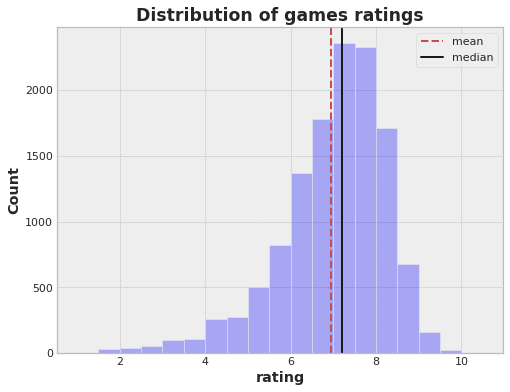

In [12]:
# Visualize the distribution or rating
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x='rating',data=games,bins=np.arange(1,11,0.5),ax=ax,alpha=0.3)
plt.axvline(games.rating.mean(),color='r',ls='--',label='mean')
plt.axvline(games.rating.median(),color='k',ls='-',label='median')
plt.title('Distribution of games ratings')
plt.legend()
plt.show()

## <span style="font-family:monospace; margin-left: 25px">5.4 Lowest Rated Games</span>

<p style = "font-family:georgia, serif; font-size:17px">
CrazyBus, Animal Soccer World, Action 52 and Plumbers Dont Wear Ties are the lowest rated games at 1.0, 1.2, 1.3 and 1.3 respectively. Ride to Hell: Retribution and Superman both tie at 1.4. This is perhaps surprisingly, since we expected old games produced between 1940s and 1970s to have the lowest ratings.
</p>    

In [13]:
games.nsmallest(10,'rating')

,title,year,genre,rating,votes,directors,plot,decade
12634,CrazyBus,2004.0,"Adventure, Family",1.0,126,Tom Maneiro,You get to select your bus and drive it across...,2000.0
12633,Animal Soccer World,2005.0,"Animation, Sport",1.2,125,Roswitha Haas,Everybody is busy with the preparations for th...,2000.0
12631,Action 52,1991.0,"Action, Family, Fantasy",1.3,135,"Raul Gomila, Vince Perri",Play the action at your fingertips with 52 gam...,1990.0
12632,Plumbers Don't Wear Ties,1994.0,"Comedy, Romance",1.3,338,Michael Anderson,"John, an unattached plumber, meets and falls i...",1990.0
12629,Ride to Hell: Retribution,2013.0,"Action, Crime, Thriller",1.4,307,Missing,"A Vietnam veteran, who has recently returned h...",2010.0
12630,Superman,1999.0,"Action, Adventure, Family",1.4,646,Missing,The first 3D Superman game. Your friends Lois ...,1990.0
12624,Hunt Down the Freeman,2018.0,"Action, Adventure, Sci-Fi",1.5,229,Berkan Denizyaran,This one guy tickle another dude's balls for m...,2010.0
12625,E.T. Phone Home!,1983.0,"Adventure, Family, Sci-Fi",1.5,28,Missing,The infamous Atari video game from the blockbu...,1980.0
12626,Jenga World Tour,2007.0,Action,1.5,17,Missing,"Video game based on the Jenga puzzle game, tak...",2000.0
12627,Super Noah's Ark 3D,1994.0,Action,1.5,42,Missing,Noah has to feed the animals in his Ark.,1990.0


## <span style="font-family:monospace; margin-left: 25px">5.5 Lowest Rated vs Decade Produced</span>

<p style = "font-family:georgia, serif; font-size:17px">
In the 100 lowest rated games, almost half (41) are produced between 2010 and 2019 while 20 are produced between 2000 and 2009 and another 20 between 1990 and 1999. The 1970s only account for 4 games. The 2020s decade has already produced 6 lowly rated games.
</p>    

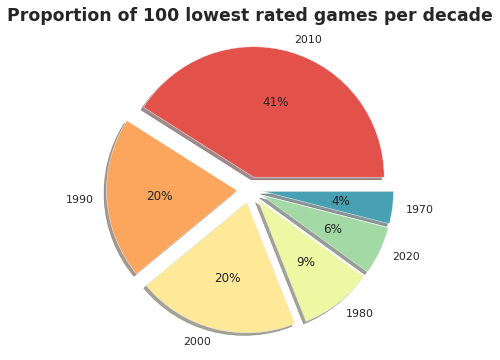

In [14]:
# Which decade produced majority of the lowest 100 rated games
lowest_rated_100 = games.loc[games.rating.nsmallest(100).index,['decade']].value_counts().reset_index()
lowest_rated_100['decade'] = lowest_rated_100.decade.astype('int')

# Visualize
sns.set_palette('Spectral')
fig, ax = plt.subplots(figsize=(8,6))
plt.pie(lowest_rated_100[0],labels=lowest_rated_100.decade,shadow=True,autopct='%1.0f%%',
        explode=[0.1,0.1,0.1,0.1,0.1,0.1])
ax.set(title='Proportion of 100 lowest rated games per decade')
plt.show()

## <span style="font-family:monospace; margin-left: 25px">5.6 Lowest rated games in 2020s</span>

<div style = "font-family:georgia, serif; font-size:17px">
Even with the advent of technology such as Cloud Gaming, Esports, Fantasy Sports, Virtual Reality, Online Gaming and powerful consoles, the 2020s managed to produce two games with low ratings of 1.8. These are: 
<ul>
<li>Taishogun: The Rise of Emperor (2021)</li>
<li>Shadow the Ronin (2020)</li>
</ul> 
</div>    

In [15]:
# Get the least rated games
lowest_rated_games = games.loc[games.rating.nsmallest(100).index,['title','year','rating','votes','decade']]

# Get the lowest rated games in 2020s
lowest_rated_games_2020s = lowest_rated_games.loc[lowest_rated_games.decade==2020,['title','year','rating','votes']]
display(lowest_rated_games_2020s)

,title,year,rating,votes
12611,Taishogun: The Rise of Emperor,2021.0,1.8,21
12612,Shadow the Ronin,2020.0,1.8,37
12592,Chickens on the Road,2020.0,2.0,17
12577,Fast and Furious Crossroads,2020.0,2.2,368
12552,eFootball 2022,2021.0,2.4,216
12553,Road Bustle,2020.0,2.4,25


## <span style="font-family:monospace; margin-left: 25px">5.6 Game Weighted Ranking</span>

<div style = "font-family:georgia, serif; font-size:17px">
    
Ranking of the video games is reflected by a balance between number of votes and rating. 

While the formula is not explicitly given by imdb, a number of websites including stack overflow have confirmed it's reliability. You are free to try other reliable formulae for this ranking. The formula ratings and votes to compute the weighted rating as follows:

```Weighted rating (WR) = (v/(v + m)) * R + ( m / (v + m)) * C```

<p>where:</p>
<ul>
    <li>R = average for the movie (mean) = (Rating)</li>
    <li>v = number of votes for the movie = (votes)</li>
    <li>m = minimum votes required to be listed in the Top 50 (currently 1000)</li>
    <li>C = the mean vote across the whole report (currently 6.95)</li>
</ul>
<b>As shown, the weighed rating uses both the ratings and number of votes to generate the ranking</b>

</div>    

In [16]:
v = games.votes
m = 1000
R = games.rating
C = games.rating.mean()

# Create the weighted rating column
games['weighted_rating'] = ((v/(v + m)) * R + ( m / (v + m)) * C)

# sorting by the weighted rating in descending order
games_ranking = games.sort_values('weighted_rating',ascending=False).reset_index().drop('index',axis=1)

# Show top 50 results 
display(games_ranking[['title','rating','votes','weighted_rating']].nlargest(50,'weighted_rating'))

,title,rating,votes,weighted_rating
0,The Last of Us,9.7,61103,9.655640
1,Red Dead Redemption II,9.7,36441,9.626420
2,The Witcher 3: Wild Hunt,9.7,26328,9.599191
3,God of War,9.6,26507,9.503483
4,Grand Theft Auto V,9.5,60381,9.458376
5,Uncharted 4: A Thief's End,9.5,28985,9.414794
6,Red Dead Redemption,9.5,26767,9.407988
7,Metal Gear Solid,9.6,11809,9.392732
8,The Witcher 3: Wild Hunt - Blood and Wine,9.7,7610,9.380035
9,Mass Effect 2,9.5,19961,9.378112


# <span style="font-family:monospace">6. Correlation</span>

## <span style="font-family:monospace; margin-left: 25px">6.1 Has the average rating of video games changed or remained constant over the years?</span>

<p style = "font-family:georgia, serif; font-size:17px">
There seems to be a positive correlation between the year and average rating of the video games. In addition, if the regression line is accurate, old games in the 50s and 60s would expected to have an average rating lower than 6.2. However, all games produced in that time period are rated higher than that. This actually obeys the "Regression to the Mean" rule. 
</p>    

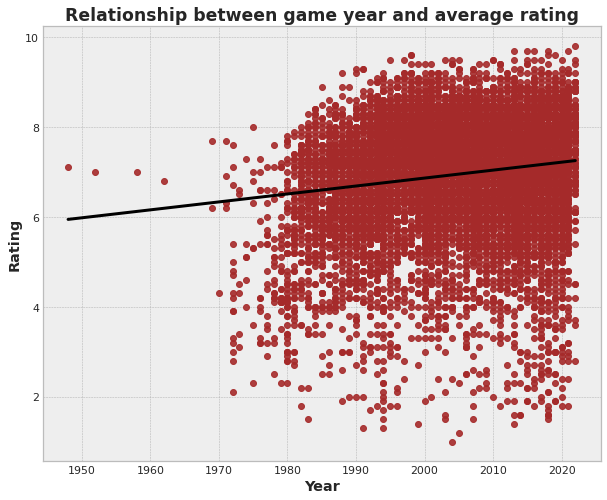

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x='year',y='rating',data=games,color='brown',line_kws={'color':'black'},ci=None,scatter_kws={'marker':'s','alpha':0.9})
ax.set(title='Relationship between game year and average rating',xlabel='Year',ylabel='Rating')
plt.show()

## <span style="font-family:monospace; margin-left: 25px">6.2 Votes and Rating</span>

<p style = "font-family:georgia, serif; font-size:17px">
There is a non-linear relationship between game rating and the number of votes
</p>

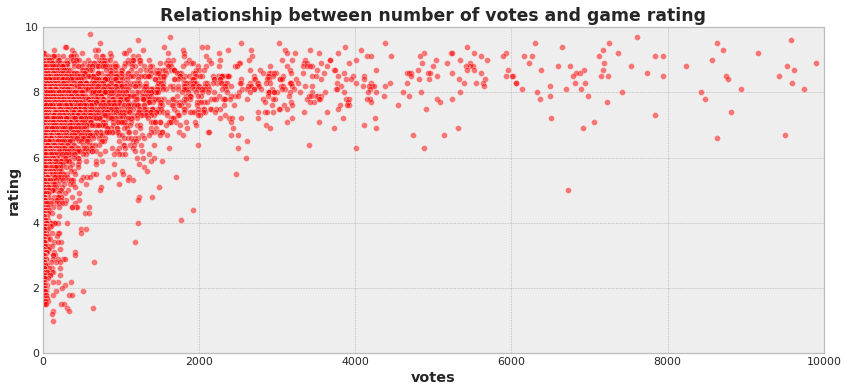

In [18]:
# Relationship between the number of votes and rating
fig, ax = plt.subplots(figsize=(14,6),)
sns.scatterplot(x='votes',y='rating',data=games,color='red',alpha=0.5)
ax.set(xlim = [0,10000],ylim=[0,10], title='Relationship between number of votes and game rating')
plt.show()

## <span style="font-family:monospace; margin-left: 25px">6.3 Transformation of variables</span>

<p style = "font-family:georgia, serif; font-size:17px">
Since the relationship between number of votes and rating is non-linear, transform the variables using square root, square, cube and log and try them all. In our case, there was a linear relationship between the log of rating and log of votes.
</p>    

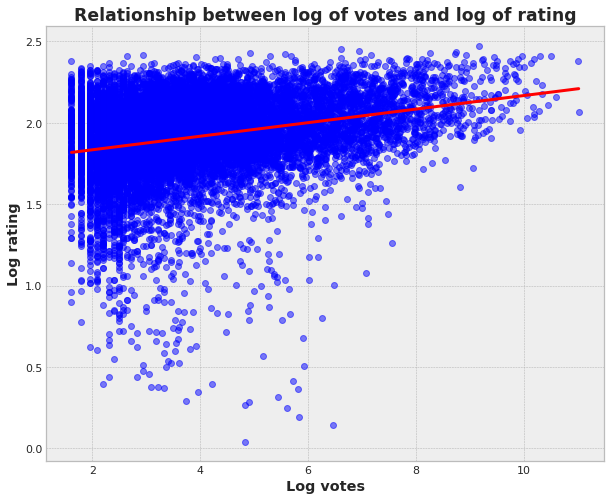

In [19]:
# Transform the variables
games['rating_log'] = np.log(games['rating'])
games['votes_log'] = np.log(games['votes'])

# Get the standard deviation of rating cubed to add noise to the scatterplot
games_rating_log_std = games.rating_log.std()

# Visualize the relationship of transformed variables
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x='votes_log',y='rating_log',data=games,color='blue',ci=None,
            y_jitter=games_rating_log_std,line_kws={'color':'red'},scatter_kws={'alpha':0.5})
ax.set(title='Relationship between log of votes and log of rating',xlabel='Log votes',ylabel='Log rating')
#plt.ylim([0,1100])
plt.show()

# <span style="font-family:monospace">7. Regression</span>

<div style = "font-family:georgia, serif; font-size:17px">
    
Since we have determined that rating is affected by the year and log of votes, we'll create a model to predict the rating of a game using the two variables.

From our model summary results, the R-squared value is only 0.109 an indication that the independent variables account for only 10.9% of variation in the dependent variable. 

Another parameter `P>|t|` shows that our two variables year and log votes are statistically significant in explaining the dependent variable - rating.

</div>    

In [20]:
# Define model 
model = ols('rating_log ~ votes_log + year',data=games).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rating_log   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     764.5
Date:                Fri, 24 Mar 2023   Prob (F-statistic):          5.40e-314
Time:                        09:46:01   Log-Likelihood:                 1809.7
No. Observations:               12532   AIC:                            -3613.
Df Residuals:                   12529   BIC:                            -3591.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4212      0.348     -6.955      0.000      -3.104      -1.739
votes_log      0.0399      0.001     35.515      0.000       0.038       0.042
year           0.0021      0.000     11.988      0.000       0.002       0.002
==============================================================================
Omnibus:                     7200.950   Durbin-Watson:                   0.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80975.780
Skew:                          -2.575   Prob(JB):                         0.00
Kurtosis:                      14.338   Cond. No.                     3.73e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# <span style="font-family:monospace">8. Making predictions</span>

<p style = "font-family:georgia, serif; font-size:17px">We will attempt extrapolation by making predictions of values outside our data range.</p> 

In [21]:
# Generate sample values to predict
votes_log = np.log(np.arange(1,500,30))
year = np.arange(1940,2061,5)

# Create different combinations for the votes_log and year
p= product(votes_log,year)

# Create dataframe to hold the values to be used for prediction
prediction_data = pd.DataFrame(p,columns=['votes_log','year'])
display(prediction_data)

,votes_log,year
0,0.000000,1940
1,0.000000,1945
2,0.000000,1950
3,0.000000,1955
4,0.000000,1960
...,...,...
420,6.175867,2040
421,6.175867,2045
422,6.175867,2050
423,6.175867,2055


In [22]:
# Generate the predictions using the model and store the result in the prediction dataset
prediction_data = prediction_data.assign(rating_log=model.predict(prediction_data))
display(prediction_data.head())

,votes_log,year,rating_log
0,0.0,1940,1.623234
1,0.0,1945,1.633658
2,0.0,1950,1.644082
3,0.0,1955,1.654505
4,0.0,1960,1.664929


## <span style="font-family:monospace; margin-left: 25px">8.1 Back-transforming the variables</span>

<div style = "font-family:georgia, serif; font-size:17px">
    
Since the predictions were made using the log of votes and log of rating, to convert these values to their respective antilogs, we use `np.exp`.
    
</div>

In [23]:
# Back transforming the log of votes to votes
prediction_data['votes'] = np.exp(prediction_data['votes_log'])

# Back transforming the log of rating to rating (antilog of the log of rating)
prediction_data['rating'] = np.exp(prediction_data['rating_log'])

## <span style="font-family:monospace; margin-left: 25px">8.2 Predictions</span>

<p style = "font-family:georgia, serif; font-size:17px">
The linear regression equation has been used to predict the average rating of video games using the year of launch and the number of votes.
</p>    

In [24]:
display(prediction_data)

,votes_log,year,rating_log,votes,rating
0,0.000000,1940,1.623234,1.0,5.069458
1,0.000000,1945,1.633658,1.0,5.122578
2,0.000000,1950,1.644082,1.0,5.176254
3,0.000000,1955,1.654505,1.0,5.230492
4,0.000000,1960,1.664929,1.0,5.285299
...,...,...,...,...,...
420,6.175867,2040,2.078238,481.0,7.990375
421,6.175867,2045,2.088661,481.0,8.074100
422,6.175867,2050,2.099085,481.0,8.158703
423,6.175867,2055,2.109509,481.0,8.244193


## <span style="font-family:monospace; margin-left: 25px">8.3 Predictions Overview</span>

<div style = "font-family:georgia, serif; font-size:17px">
    
Using 1950 and 2050 to show the contrast in the predictions, games produced in 1950 and have 1 vote would have likely had a rating of 5.2 while those produced in 2050 with 1 vote are likely to have a rating of 6.4.

On the other hand, a game produced in 1950 and having 481 votes would have likely had a rating of 6.6 while those produced in 2050 with similar votes would likely have a rating of 8.2.

</div>    

In [25]:
# Display year, votes and rating in predicted data for years 1950 and 2050
display(prediction_data.loc[(prediction_data['year']==1950) | (prediction_data['year']==2050),
                            ['year','votes','rating']])

,year,votes,rating
2,1950,1.0,5.176254
22,2050,1.0,6.376107
27,1950,31.0,5.936734
47,2050,31.0,7.312865
52,1950,61.0,6.099330
72,2050,61.0,7.513152
77,1950,91.0,6.197497
97,2050,91.0,7.634074
102,1950,121.0,6.268389
122,2050,121.0,7.721399


# <span style="font-family:monospace">9. Conclusion</span>

<div style = "font-family:georgia, serif; font-size:17px">
<ul>
 <li>On average, games seem to get better and better with time</li>
 <li>Games with more votes tend to have higher ratings</li>
 <li>The top 20 highest rated games are produced after 1998 with ratings above 9.5</li>
 <li>At the same time, 33 games have been produced with ratings below 2.1</li>
</ul>
</div>    